# Continuous Control Solved Using A2C

### Udacity Project Submission by Jayanth Nair

This notebook walks through the implementation of the A2C algorithm to solve the UnityML Reacher environment (with 20 agents running parallely)

In [1]:
# necessary imports to get environment up and running
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_ParallelAgents/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# obtaining brain information
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### A2C Implementation Details

The A2C network architecture used in this project handles continuous action spaces. (From Maxim Lapan's book Deep Reinforcement Learning Hands-On)

#### Neural Network Architecture

The A2C network architecture used in this project handles continuous action spaces.  The neural network contains of two common fully connected linear layers with three heads.  The three heads predict the average action values, the variance of the actions and the value of the state.

The common body of the network contains an input layer of 128 units and a hidden layer of 128 units.  Each of these layers use the ReLu activation function.  The average action values head contains a fully connected layer of 128 units with an output layer of 4 units (corresponding to the action size).  The output layer uses a Tanh activation function to ensure the action lies between -1 and 1. The action values variance head contains a fully connected layer of 128 units with an output layer of 4 units.  The output layer uses a softplus activation function. The state value head consists of 1 fully connected layer of 128 units with an output layer with 1 unit.


#### Agent Hyper-parameters

| Hyper-parameter | Value |
| :-------------- | ----: |
| Discount Factor (Gamma) | 0.99 |
| Learning Rate | 0.00005 |
| Entropy Beta | 0.0001|

In [5]:
# import modules
import torch
%load_ext autoreload
%aimport a2c_multiagent 
from a2c_multiagent import Agent
import matplotlib.pyplot as plt
from collections import deque

In [6]:
agent = Agent(state_size,action_size,random_seed=2,n_steps=6)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
def a2c_multiagent(agent,print_every=10):
    env_info = env.reset(train_mode=True)[brain_name] 
    states = env_info.vector_observations
    init_states = states

    n_episodes = 1
    n_steps = 10
    episode_end = False
    scores = []
    scores_deque = deque([0], maxlen=100) # initialize with 0
    ep_rewards = 0
    best_score = 0.
    while True:
        states_t,actions_t,final_rewards,init_states,accu_rewards,episode_end = agent.play_n_steps(env,brain_name,init_states,episode_end)

        agent.learn(states_t,actions_t,final_rewards)
        ep_rewards += np.sum(accu_rewards)
        score = ep_rewards/num_agents
        
        print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(n_episodes,round(score,2),round(np.mean(scores_deque),2)),end="")

        
        if episode_end==True:
            if n_episodes % 10 == 0:
                print('\rEpisode # - {0},\tAverage Score - {1},\tAverage Score over 100 Episodes-{2}'.format(n_episodes, round(score,2),round(np.mean(scores_deque),2)))
            
            if score > best_score:
                print('\rScore of {0} better than previous best score of {1} - Saving weights!'.format(round(score,2),round(best_score,2)))
                torch.save(agent.net.state_dict(),'a2c_checkpoint.pth')
                best_score = score
            if score>30 and np.mean(scores_deque) >= 30:
                print('\rReacher environment with 20 agents solved in {0} episodes!'.format(n_episodes))
                break
            scores.append(score)
            scores_deque.append(score)
            ep_rewards = 0
            n_episodes += 1
            episode_end=False


    return scores

Score of 0.82 better than previous best score of 0.0 - Saving weights!.0
Score of 0.84 better than previous best score of 0.82 - Saving weights!41
Score of 1.03 better than previous best score of 0.84 - Saving weights!55
Score of 1.03 better than previous best score of 1.03 - Saving weights!74
Score of 1.07 better than previous best score of 1.03 - Saving weights!79
Episode # - 10,	Average Score - 1.25,	Average Score over 100 Episodes-0.87
Score of 1.25 better than previous best score of 1.07 - Saving weights!
Score of 1.29 better than previous best score of 1.25 - Saving weights!.96
Episode # - 20,	Average Score - 1.29,	Average Score over 100 Episodes-0.98
Score of 1.36 better than previous best score of 1.29 - Saving weights!.01
Score of 1.41 better than previous best score of 1.36 - Saving weights!.02
Score of 1.55 better than previous best score of 1.41 - Saving weights!.04
Score of 1.55 better than previous best score of 1.55 - Saving weights!.06
Score of 1.66 better than previous

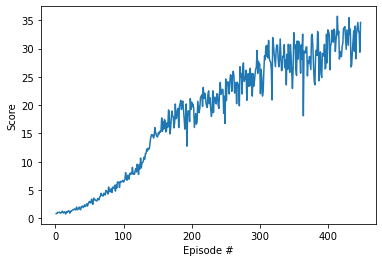

In [13]:
scores = a2c_multiagent(agent)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()